In [315]:
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
import re
from utils import preprocess_image

In [316]:
LABEL_PATH = 'coco_labels.txt'
labels = dict()
with open(LABEL_PATH, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number] = pair[0].strip()
print(labels)
colors = np.random.randint(0, 255, size=(len(labels), 3),dtype="int32")

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic', 10: 'fire', 11: 'stop', 12: 'parking', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports', 33: 'kite', 34: 'baseball', 35: 'baseball', 36: 'skateboard', 37: 'surfboard', 38: 'tennis', 39: 'bottle', 40: 'wine', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted', 59: 'bed', 60: 'dining', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book'

In [317]:
np.random.seed(2000)
img_path = './images/street.jpg'
tflite_model = '../tflite_models/float32/mobiledet_frozen.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
img_shape = tuple(input_shape[1:3])
img_type = input_details[0]['dtype']
print(img_shape, img_type)


(320, 320) <class 'numpy.float32'>


In [318]:
# For this network input must be a tf.Tensor
img = tf.io.read_file(img_path)
img = tf.io.decode_image(img, channels=3)
original_img = img.numpy()
if type == np.uint8:
    img = tf.image.convert_image_dtype(img, tf.uint8)
else:
    img = tf.image.convert_image_dtype(img, tf.float32)
scaled_img = tf.image.resize(img, (320, 320))
scaled_img = scaled_img[tf.newaxis, :]

In [319]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
bboxes = interpreter.get_tensor(output_details[0]['index']).squeeze()
class_ids = interpreter.get_tensor(output_details[1]['index']).squeeze()
scores = interpreter.get_tensor(output_details[2]['index']).squeeze()
num_detections = interpreter.get_tensor(output_details[3]['index']).squeeze()

In [320]:
# Perform non-max-suppresion and overwrite original outputs
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.5
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

[ 500 357 746 587 ] 0.78 bus
[ 917 493 960 602 ] 0.78 person
[ 0 356 1161 788 ] 0.74 person
[ 376 368 502 552 ] 0.74 bus
[ 751 498 791 592 ] 0.73 person
[ 867 493 903 588 ] 0.73 person
[ 1090 493 1130 598 ] 0.70 person
[ 819 498 850 585 ] 0.69 person
[ 1044 506 1075 577 ] 0.67 person
[ 802 377 835 438 ] 0.66 traffic
[ 313 449 364 587 ] 0.65 person
[ 989 497 1021 578 ] 0.62 person
[ 964 567 1039 751 ] 0.61 person
[ 155 607 246 798 ] 0.60 person
[ 19 648 81 791 ] 0.59 person
[ 114 620 158 698 ] 0.58 person
[ 1049 525 1082 619 ] 0.58 person
[ 1048 483 1074 530 ] 0.56 person
[ 270 511 307 629 ] 0.56 person
[ 228 644 285 778 ] 0.56 person
[ 187 528 223 641 ] 0.56 person
[ 164 554 195 616 ] 0.55 person
[ 1048 550 1144 776 ] 0.53 person
[ 94 512 123 577 ] 0.53 person
[ 1140 504 1174 580 ] 0.52 person
[ 26 507 64 592 ] 0.51 person
[ 1140 570 1192 659 ] 0.51 person
[ 75 648 119 787 ] 0.50 person


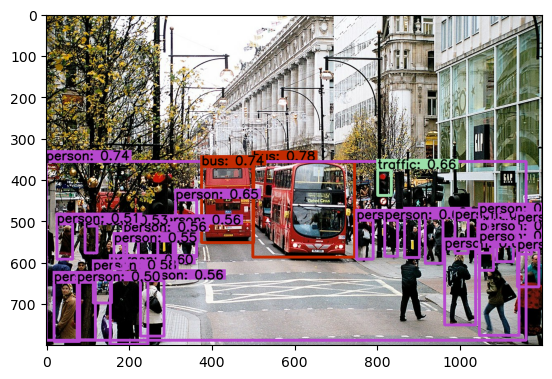

In [321]:
for bbox, class_id, score in zip(bboxes, class_ids, scores):
    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])
    y_min_ratio, x_min_ratio, y_max_ratio, x_max_ratio = bbox

    x_min = int(x_min_ratio * original_img.shape[1])
    y_min = int(y_min_ratio * original_img.shape[0])
    x_max = int(x_max_ratio * original_img.shape[1])
    y_max = int(y_max_ratio * original_img.shape[0])

    print('[',x_min, y_min, x_max, y_max,']', f'{score:.2f}', label)
    # Drawing bounding box
    cv2.rectangle(original_img, (x_min, y_min), (x_max, y_max), color, 6)
    
    # Drawing label
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    detection_info = f'{label}: {score:.2f}'
    label_size = cv2.getTextSize(detection_info, font_face, font_scale, font_thickness)[0]
    label_x_min, label_y_min = x_min - 3, y_min - 3
    label_x_max, label_y_max = x_min + 3 + label_size[0], y_min - 5 - label_size[1]
    cv2.rectangle(original_img, (label_x_min, label_y_min), (label_x_max, label_y_max), color, -1)
    cv2.putText(original_img, detection_info, (x_min, y_min - 4), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
plt.imshow(original_img)
